This notebook adresseses an employee scheduling problem involving multiple employees and tasks. 

The objective studied is minimizing the latest completion time  of tasks (makespan). 

Each task should be assigned to an employee and preemption is not allowed. The duration of tasks is fixed (independent of the assigned employee) and it is assumed that each task can be assigned to any employee (all employees are capable to process all tasks). Finally, employees are associated with availability start and end times.

The scheduling problem can be also viewed as machine scheduling problem in which employees correspond to machines. 

In [6]:
import pandas as pd
import math
import os
import numpy as np
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

DATAFILE_PATH = os.path.join("data", "MasterData.xlsx")
NB_EMPLOYEES = 5
NB_TASKS = 30

# READ DATA

In [5]:
employeesTable = pd.read_excel(DATAFILE_PATH, sheet_name='Employees', header=0)
employeesTable = employeesTable.head(NB_EMPLOYEES) # select only NB_EMPLOYEES employees in order to have a small-sized problem
employeesTable

,name,availability_start,availability_end,seniority,qualification,pay_rate
0,Anne,480,1020,11,1,25
1,Bethanie,480,1020,4,5,28
2,Betsy,480,1020,2,2,17
3,Cathy,480,1020,2,2,17
4,Cecilia,480,1020,9,5,38


In [7]:
tasksTable = pd.read_excel(DATAFILE_PATH, sheet_name='Tasks', header=0)
tasksTable=tasksTable.head(NB_TASKS) # select only NB_TASKS tasks in order to have a small-sized problem
tasksTable

,task_id,task_type,task_duration,required_nbr_of_employees
0,T001,Pediatrics,110,1
1,T002,Oncology,30,1
2,T003,Anaesthesiology,90,1
3,T004,Geriatrics,90,1
4,T005,Anaesthesiology,90,2
5,T006,Geriatrics,50,2
6,T007,Oncology,60,2
7,T008,Geriatrics,40,1
8,T009,Anaesthesiology,90,1
9,T010,Pediatrics,120,1


# PREPARE DATA

Tuple data type can be used to retrieve certain values of each row of a dataframe (to be used in the optimization  model). Each tuple set can correspond to an input table and the pandas method itertuples() returns a named tuple for each row of a DataFrame. 

In [8]:
employeesT  = namedtuple("employeesT",['name', 'availabilityStart', 'availabilityEnd', 'seniority', 'qualification', 'payRate'])
employees  = [employeesT(*employees_row) for employees_row in employeesTable.itertuples(index=False)]
# employees 

In [9]:
tasksT  = namedtuple("tasksT",['taskId', 'taskType', 'taskDuration','requiredNbrOfEmployees'])
tasks  = [tasksT(*tasks_row) for tasks_row in tasksTable.itertuples(index=False)]
# tasks 

# CREATE A MODEL INSTANCE

In [10]:
from docplex.cp.model import *
mdl = CpoModel(name='employeeScheduling') 

# DEFINE DECISION VARIABLES

In [11]:
# define processing interval of each task at each employee
tasks_itv_vars = {}   
for e in employees:
    for t in tasks:
        tasks_itv_vars[t,e] = mdl.interval_var(start=(e.availabilityStart,e.availabilityEnd), end=(e.availabilityStart,e.availabilityEnd),optional=True, size=t.taskDuration, name="interval_task{}_employee{}".format(t.taskId,e.name))
        #print(tasks_itv_vars[t,e])

# EXPRESS OBJECTIVE FUNCTION

In [12]:
# minimize makespan
objective = mdl.max([mdl.end_of(tasks_itv_vars[t,e]) for t in tasks for e in employees])
mdl.add(mdl.minimize(objective)) 

# DEFINE CONSTRAINTS

In [13]:
# each task should be assigned to an employee
for t in tasks:
    mdl.add(mdl.sum([mdl.presence_of(tasks_itv_vars[t,e]) for e in employees]) == 1)

In [14]:
# no overlap constraint
for e in employees:
    mdl.add(mdl.no_overlap([tasks_itv_vars[t,e] for t in tasks])) 

# SOLVE THE MODEL

In [20]:
msol = mdl.solve(TimeLimit=60,
                 log_output=True, # set to None to suppress output
                 LogPeriod=1_000_000,
                )

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 155 variables, 35 constraints
 ! TimeLimit            = 60
 ! LogPeriod            = 1000000
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 1085.8 (before), 1085.8 (after)
 !  . Memory usage      : 997.2 kB (before), 997.2 kB (after)
 ! Using parallel search with 10 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        155                 -
 + New bound is 0
 ! Using iterative diving.
 *          1020      233  0.14s        1      (gap is 100.0%)
 *          1010      393  0.14s        1      (gap is 100.0%)
 *          1000      505  0.14s        1      (gap is 100.0%)
 *           990      750  0.14s        1      (gap is 100.0%)
             990     6150          1    1   F        -
 + New bound is 6

# PREPARE OUTPUT TABLES

In [21]:
assignmentReport = [(e.name, t.taskId, t.taskDuration, 
                     msol.get_var_solution(tasks_itv_vars[t,e]).get_start(),msol.get_var_solution(tasks_itv_vars[t,e]).get_end()) 
                       for t in tasks for e in employees if msol.get_var_solution(tasks_itv_vars[t,e]).is_present()]
assignmentReport_df = pd.DataFrame(assignmentReport, columns=['Employee', 'Task', 'Duration','StartTime','EndTime'])
assignmentReport_df = assignmentReport_df.sort_values(by=['Employee', 'StartTime'], ascending=[True, True])
assignmentReport_df 

,Employee,Task,Duration,StartTime,EndTime
12,Anne,T013,120,480,600
16,Anne,T017,110,600,710
17,Anne,T018,100,710,810
21,Anne,T022,90,810,900
23,Anne,T024,50,900,950
7,Anne,T008,40,950,990
11,Bethanie,T012,120,480,600
28,Bethanie,T029,110,600,710
2,Bethanie,T003,90,710,800
4,Bethanie,T005,90,800,890


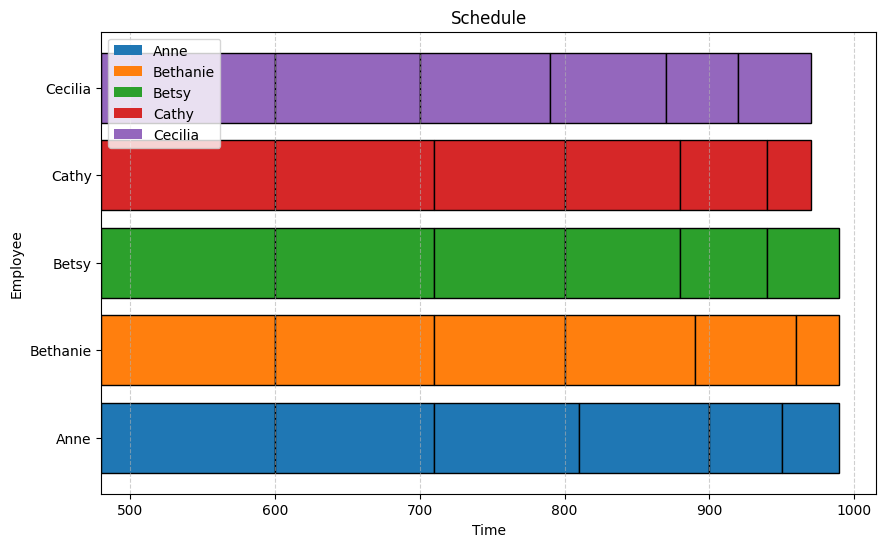

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Your data
df = assignmentReport_df

# Automatically define colors for resources using a colormap
cmap = plt.cm.get_cmap('tab10')  # You can choose other colormaps
colors = [cmap(i) for i in range(len(df['Employee'].unique()))]
resource_colors = dict(zip(df['Employee'].unique(), colors))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Gantt chart
for i, row in df.iterrows():
    start_time = row['StartTime']
    end_time = row['EndTime']
    task_duration = end_time - start_time
    ax.barh(row['Employee'], task_duration, left=start_time, color=resource_colors[row['Employee']], edgecolor='black', label="EEEE")

# Customize the chart
ax.set_xlabel('Time')
ax.set_ylabel('Employee')
ax.set_title('Schedule')

# Customize legend
legend_labels = [plt.Rectangle((0,0), 1, 1, fc=resource_colors[resource]) for resource in df['Employee'].unique()]
ax.legend(legend_labels, df['Employee'].unique())

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()